# Pendulum

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:
$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    \pi & 0
    \end{bmatrix}
\end{equation*}
$$

**Note**: The force is constrained between $-2.5$ and $2.5$ Nm.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import matplotlib.pyplot as plt

In [4]:
import pddp
import pddp.examples

In [5]:
import torch
import numpy as np

In [6]:
DT = 0.1  # Time step (s).
N = 40  # Horizon length.
RENDER = True  # Whether to render the environment or not.

# Disable uncertainty since we are dealing with known dynamics.
ENCODING = pddp.StateEncoding.IGNORE_UNCERTAINTY

In [7]:
cost = pddp.examples.pendulum.PendulumCost()
model = pddp.examples.pendulum.PendulumDynamicsModel(DT)
env = pddp.examples.pendulum.PendulumEnv(dt=DT, render=RENDER)

In [8]:
def plot(Z, U):
    t = np.arange(N + 1) * DT
    X = pddp.utils.encoding.decode_mean(Z, ENCODING).detach().numpy()
    U = model.constrain(U).detach().numpy()

    theta = np.unwrap(X[:, 0])  # Makes for smoother plots.
    theta_dot = X[:, 1]
    
    plt.figure()
    plt.plot(theta, theta_dot)
    plt.xlabel("Orientation (rad)")
    plt.ylabel("Angular velocity (rad/s)")
    plt.title("Orientation Phase Plot")

    plt.figure()
    plt.plot(t, theta)
    plt.xlabel("Time (s)")
    plt.ylabel("Orientation (rad)")
    plt.title("Orientation path")

    plt.figure()
    plt.plot(t, theta_dot)
    plt.xlabel("Time (s)")
    plt.ylabel("Angular velocity (rad / s)")
    plt.title("Angular velocity path")
    
    plt.figure()
    plt.plot(t[:-1], U)
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (N m)")
    plt.title("Constrained action path")
    
    plt.figure()
    plt.plot(J_hist)
    plt.xlabel("Iteration")
    plt.ylabel("Total loss")
    plt.title("Loss path")

In [9]:
def on_iteration(iteration, Z, U, J_opt, accepted, converged):
    J_opt = J_opt.detach().numpy()

    J_hist.append(J_opt)
    info = "CONVERGED" if converged else ("accepted" if accepted else "FAILED")
    final_state = Z[-1].detach().numpy()
    final_state[0] = (final_state[0] + np.pi) % (2 * np.pi) - np.pi
    print("iteration", iteration + 1, info, J_opt, final_state)

In [10]:
controller = pddp.controllers.PDDPController(env, model, cost)

In [11]:
U = torch.randn(N, model.action_size)

In [12]:
J_hist = []
controller.eval()
Z, U = controller.fit(U, encoding=ENCODING, n_iterations=200,
                      on_iteration=on_iteration)

iteration 8 accepted 499.36066 [ 0.97937304 -0.8854797 ]
iteration 9 accepted 418.2935 [ 1.1120493 -0.2252568]
iteration 10 accepted 402.36694 [1.3250463 0.0397948]
iteration 11 accepted 384.12054 [1.8633442 0.3117615]
iteration 12 accepted 287.78845 [ 1.8596087  -0.00641692]
iteration 13 accepted 227.66855 [2.29452   0.0806061]
iteration 14 accepted 221.58597 [2.3126984  0.07085049]
iteration 15 accepted 213.02736 [2.3419366  0.03660643]
iteration 16 accepted 201.7764 [2.471073   0.03401327]
iteration 17 accepted 198.70322 [2.5183275 0.0188036]
iteration 18 accepted 194.31772 [2.5441806  0.01705551]
iteration 19 accepted 192.79721 [2.5592837  0.01544619]
iteration 20 accepted 187.9782 [2.735868   0.06961739]
iteration 21 accepted 187.09444 [2.7183359  0.06489575]
iteration 22 accepted 185.09906 [2.7189486  0.03694236]
iteration 23 accepted 184.31644 [2.7172363 0.0280844]
iteration 24 accepted 182.69807 [2.7297645  0.01518512]
iteration 25 accepted 182.00877 [2.7343013  0.01340461]
ite

iteration 143 accepted 153.03479 [3.0599265e+00 9.7912550e-04]
iteration 144 accepted 152.9333 [3.0596712e+00 9.8049641e-04]
iteration 145 accepted 152.80486 [3.0614188e+00 9.7674131e-04]
iteration 146 accepted 152.74208 [3.0612895e+00 9.6631050e-04]
iteration 147 accepted 152.63959 [3.0624363e+00 9.2852116e-04]
iteration 148 accepted 152.56726 [3.0621192e+00 9.2977285e-04]
iteration 149 accepted 152.51091 [3.0627141e+00 9.1946125e-04]
iteration 150 accepted 152.45709 [3.062776e+00 9.147525e-04]
iteration 151 accepted 152.40022 [3.0634625e+00 9.0664625e-04]
iteration 152 accepted 152.354 [3.0636022e+00 9.0122223e-04]
iteration 153 accepted 152.29694 [3.0642347e+00 8.9210272e-04]
iteration 154 accepted 152.25531 [3.064397e+00 8.867383e-04]
iteration 155 accepted 152.19026 [3.0654802e+00 8.7630749e-04]
iteration 156 accepted 152.11205 [3.0653863e+00 8.7541342e-04]
iteration 157 accepted 152.01634 [3.0665948e+00 8.6295605e-04]
iteration 158 accepted 151.9571 [3.0665159e+00 8.5812807e-04]


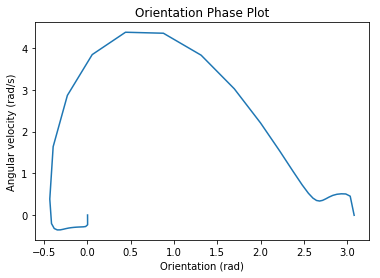

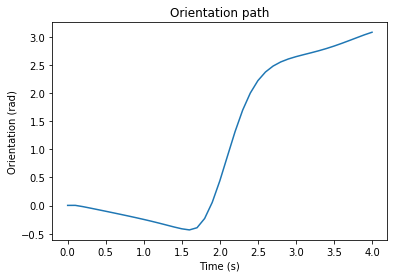

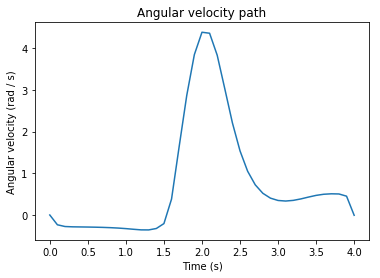

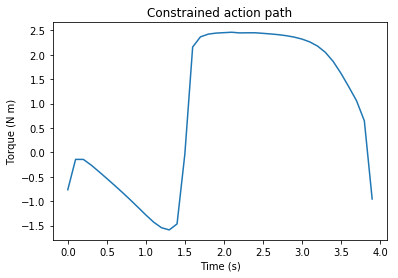

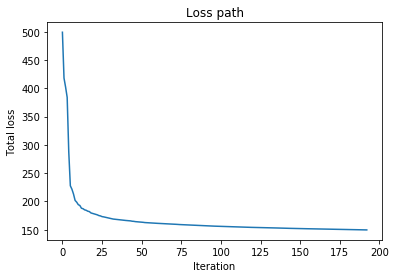

In [13]:
plot(Z, U)

In [14]:
if RENDER:
    # Wait for user interaction before visualizing. 
    _ = input("Press ENTER to continue")

Press ENTER to continue


In [15]:
for u in U:
    env.apply(u)

In [16]:
env.close()